In [1]:
#import modules we need to use for this session
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
# PCA module
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import r2_score

Before we tried to use some parameters of the house (size) to predict its price. However notice that location matters as well. Below we upload a sample of more than 14000 individual house sales all around NYC in 2012. Each record together with the parameters of the house also contains important characteristics of the location (zip code) - average income of its residents (accodring to US census), as well as the relative structure of 311 complaints happening in the area.

In [2]:
folder=''

In [3]:
REsample=pd.read_csv(folder+'data/NYChome_sales2012.csv',index_col=0)

In [4]:
len(REsample)

14611

In [5]:
REsample.head()

,borough,neighborhood,block,lot,easement,building_class_present,address,zip_code,commmercial_units,land_sq_feet,gross_sq_feet,year_built,sale_price,sale_date
204018,4,LAURELTON,12941,94,NaN,A2,131-43 FRANCIS LEWIS BLVD,11413,0,3560,1473,1940,0,2012-01-01
217555,2,BATHGATE,3046,42,NaN,A1,2069 BATHGATE AVE,10457,0,1964,1424,1899,345376,2012-04-05
217598,2,BAYCHESTER,4707,70,NaN,A5,1134 EAST 213 STREET,10469,0,2320,1813,1950,335700,2012-05-17
217599,2,BAYCHESTER,4708,48,NaN,A5,1110 EAST 214TH STREET,10469,0,1710,1813,1945,338000,2012-02-03
217600,2,BAYCHESTER,4710,1,NaN,A5,1127 EAST 215TH STREET,10469,0,2759,1998,1945,0,2012-12-20


In [6]:
REsample.columns

Index(['borough', 'neighborhood', 'block', 'lot', 'easement',
       'building_class_present', 'address', 'zip_code', 'commmercial_units',
       'land_sq_feet', 'gross_sq_feet', 'year_built', 'sale_price',
       'sale_date'],
      dtype='object')

In [7]:
#how many houses do we have per each borough?
np.bincount(REsample.borough)

array([   0,  216,  894, 2769, 7288, 3444], dtype=int64)

In [8]:
REsample.rename(columns={'zip_code':'Zip'}, inplace=True) 



In [9]:
 REsample.head()

,borough,neighborhood,block,lot,easement,building_class_present,address,Zip,commmercial_units,land_sq_feet,gross_sq_feet,year_built,sale_price,sale_date
204018,4,LAURELTON,12941,94,NaN,A2,131-43 FRANCIS LEWIS BLVD,11413,0,3560,1473,1940,0,2012-01-01
217555,2,BATHGATE,3046,42,NaN,A1,2069 BATHGATE AVE,10457,0,1964,1424,1899,345376,2012-04-05
217598,2,BAYCHESTER,4707,70,NaN,A5,1134 EAST 213 STREET,10469,0,2320,1813,1950,335700,2012-05-17
217599,2,BAYCHESTER,4708,48,NaN,A5,1110 EAST 214TH STREET,10469,0,1710,1813,1945,338000,2012-02-03
217600,2,BAYCHESTER,4710,1,NaN,A5,1127 EAST 215TH STREET,10469,0,2759,1998,1945,0,2012-12-20


In [10]:
#split into training (1), validation (2) and test (3) samples
np.random.seed(2018)
splitind=np.random.uniform(size=len(REsample))
REsample1=REsample.loc[splitind<=0.4]
REsample2=REsample.loc[(splitind>0.4)&(splitind<0.7)]
REsample3=REsample.loc[(splitind>=0.7)]

In [11]:
len(REsample1) #loosing around 50 records within sparse zip codes

5832

In [12]:
len(REsample2)

4394

In [13]:
len(REsample3)

4385

In [14]:

#REsample1.reset_index(inplace=True) 
#REsample1.rename(columns={"index": "Zip"})


In [15]:
#REsample2.reset_index(inplace=True) 
#REsample2.rename(columns={"index": "Zip"})


In [16]:
# now load and curate 311 data which we're going to use in order to characterize the location

In [17]:
data311 = pd.read_csv( folder+'data/aggr311.csv' , index_col=0 )
data311.head()

,Zip,Complain,Count
1,NaN,Adopt-A-Basket,5
2,10001,Adopt-A-Basket,1
3,10003,Adopt-A-Basket,1
4,10009,Adopt-A-Basket,1
5,10010,Adopt-A-Basket,1


In [18]:
data311.Zip=pd.to_numeric(data311.Zip,errors='coerce')

In [19]:
data311=data311.loc[(data311.Zip>=10000)&(data311.Zip<11500)] #take only NYC zip codes

In [20]:
data311=pd.pivot_table(data311,index='Zip',columns='Complain',values='Count',fill_value=0)

In [21]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,8,8,0,0,0,0,0
10001.0,0,1,90,0,0,1,20,36,1,1,...,3,0,2,51,5,5,2,366,0,0
10002.0,15,0,80,0,0,21,18,20,2,6,...,5,1,4,27,14,10,7,324,0,0
10003.0,15,1,143,0,2,44,24,13,2,2,...,7,11,2,54,25,12,5,318,0,0
10004.0,0,0,15,0,0,4,3,1,0,1,...,1,1,0,16,21,0,0,37,0,0


In [22]:
#data311.columns =  ['F%d'%(i) for i in range(1, data311.shape[1]+1)]   
#data311.shape

In [23]:
list_311=list(data311.columns)

In [24]:
Total311=data311.sum(axis=1) #total 311 activity per zip code
data311=data311.div(data311.sum(axis=1), axis=0) #normalize activity of various cathegories within zip code by total
data311=data311.loc[Total311>100] #keep only those zip codes having sufficient activity

In [25]:
len(data311) #only 179 zip codes with reliable data left

179

In [26]:
dict_complaints = dict.fromkeys(data311.columns.tolist())

In [27]:
dict_complaints

{'APPLIANCE': None,
 'Adopt-A-Basket': None,
 'Air Quality': None,
 'Animal Abuse': None,
 'Animal Facility - No Permit': None,
 'Animal in a Park': None,
 'Asbestos': None,
 'BEST/Site Safety': None,
 'Beach/Pool/Sauna Complaint': None,
 'Bike Rack Condition': None,
 'Bike/Roller/Skate Chronic': None,
 'Blocked Driveway': None,
 'Boilers': None,
 'Bottled Water': None,
 'Bridge Condition': None,
 'Broken Muni Meter': None,
 'Broken Parking Meter': None,
 'Building Condition': None,
 'Building/Use': None,
 'Bus Stop Shelter Placement': None,
 'CONSTRUCTION': None,
 'Calorie Labeling': None,
 'City Vehicle Placard Complaint': None,
 'Collection Truck Noise': None,
 'Construction': None,
 'Consumer Complaint': None,
 'Cranes and Derricks': None,
 'Curb Condition': None,
 'DOF Parking - Tax Exemption': None,
 'DPR Internal': None,
 'Damaged Tree': None,
 'Dead Tree': None,
 'Derelict Bicycle': None,
 'Derelict Vehicle': None,
 'Derelict Vehicles': None,
 'Dirty Conditions': None,
 'Disord

In [28]:
i = 1
for c in dict_complaints.keys():
    dict_complaints[c] = 'F' + str(i)
    i +=1

In [29]:
dict_complaints 

{'APPLIANCE': 'F1',
 'Adopt-A-Basket': 'F2',
 'Air Quality': 'F3',
 'Animal Abuse': 'F4',
 'Animal Facility - No Permit': 'F5',
 'Animal in a Park': 'F6',
 'Asbestos': 'F7',
 'BEST/Site Safety': 'F8',
 'Beach/Pool/Sauna Complaint': 'F9',
 'Bike Rack Condition': 'F10',
 'Bike/Roller/Skate Chronic': 'F11',
 'Blocked Driveway': 'F12',
 'Boilers': 'F13',
 'Bottled Water': 'F14',
 'Bridge Condition': 'F15',
 'Broken Muni Meter': 'F16',
 'Broken Parking Meter': 'F17',
 'Building Condition': 'F18',
 'Building/Use': 'F19',
 'Bus Stop Shelter Placement': 'F20',
 'CONSTRUCTION': 'F21',
 'Calorie Labeling': 'F22',
 'City Vehicle Placard Complaint': 'F23',
 'Collection Truck Noise': 'F24',
 'Construction': 'F25',
 'Consumer Complaint': 'F26',
 'Cranes and Derricks': 'F27',
 'Curb Condition': 'F28',
 'DOF Parking - Tax Exemption': 'F29',
 'DPR Internal': 'F30',
 'Damaged Tree': 'F31',
 'Dead Tree': 'F32',
 'Derelict Bicycle': 'F33',
 'Derelict Vehicle': 'F34',
 'Derelict Vehicles': 'F35',
 'Dirty C

In [30]:
data311 = data311.rename(columns=dict_complaints)

In [31]:
data311.columns

Index(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10',
       ...
       'F153', 'F154', 'F155', 'F156', 'F157', 'F158', 'F159', 'F160', 'F161',
       'F162'],
      dtype='object', name='Complain', length=162)

#### Q1. Run linear regression 'sale_price ~ gross_sq_feet+land_sq_feet+year_built' over the training data

In [32]:
lm = smf.ols(formula='sale_price ~ gross_sq_feet+land_sq_feet+year_built', data = REsample1).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     342.8
Date:                Wed, 20 Nov 2019   Prob (F-statistic):          5.23e-205
Time:                        17:08:32   Log-Likelihood:                -88308.
No. Observations:                5832   AIC:                         1.766e+05
Df Residuals:                    5828   BIC:                         1.767e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      7.637e+06   8.92e+05      8.561

#### Q2. Add 311 data corresponding to the zip code of the house location to REsample1,2,3 
in order to characterize the house's neighborhood by merging the dataframes REsample1,2,3 with data311 by zip code. Name merged dataframes REsample1_311, REsample2_311, REsample3_311 
rename 311 columns to F1,F2,... for easier formulae engineering
but keep the original names as a dictionary {'F1':'APPLIANCE', ...}

In [33]:
data311.head()

Complain,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,0.000000,0.000000,0.008772,0.0,0.000000,0.008772,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.070175,0.070175,0.000000,0.000000,0.000000,0.0,0.0
10001.0,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,0.005272,0.000146,0.000146,...,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002.0,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,0.001774,0.000177,0.000532,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003.0,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,0.001154,0.000177,0.000177,...,0.000621,0.000976,0.000177,0.004792,0.002218,0.001065,0.000444,0.028219,0.0,0.0
10004.0,0.000000,0.000000,0.009740,0.0,0.000000,0.002597,0.001948,0.000649,0.000000,0.000649,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.0,0.0


In [34]:


REsample1_311 = pd.merge(REsample1, data311,how='inner',on=['Zip'])


REsample1_311.head()


,borough,neighborhood,block,lot,easement,building_class_present,address,Zip,commmercial_units,land_sq_feet,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
0,2,BATHGATE,3046,42,NaN,A1,2069 BATHGATE AVE,10457,0,1964,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
1,2,MOUNT HOPE/MOUNT EDEN,2790,53,NaN,A1,1693 CLAY AVENUE,10457,0,3610,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
2,2,MOUNT HOPE/MOUNT EDEN,2791,36,NaN,A1,1690 MONROE AVENUE,10457,0,2375,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
3,2,MOUNT HOPE/MOUNT EDEN,2802,33,NaN,A1,258 MOUNT HOPE PLACE,10457,0,2375,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
4,2,BAYCHESTER,4708,48,NaN,A5,1110 EAST 214TH STREET,10469,0,1710,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.046250,0.000101,0.0


In [35]:
REsample2_311 = pd.merge(REsample2, data311,how='inner',left_on=['Zip'], right_index=True)
REsample2_311 .head()

,borough,neighborhood,block,lot,easement,building_class_present,address,Zip,commmercial_units,land_sq_feet,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
217600,2,BAYCHESTER,4710,1,NaN,A5,1127 EAST 215TH STREET,10469,0,2759,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0
217601,2,BAYCHESTER,4710,1,NaN,A5,1127 EAST 215TH STREET,10469,0,2759,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0
217603,2,BAYCHESTER,4715,22,NaN,A5,1156 EAST 221 STREET,10469,0,1842,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0
217612,2,BAYCHESTER,4730,10,NaN,A1,1320 EAST 222 STREET,10469,0,1938,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0
217614,2,BAYCHESTER,4730,45,NaN,A5,3418 GUNTHER AVENUE,10469,0,1710,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0


In [36]:
REsample3_311 = pd.merge(REsample3, data311,how='inner',left_on=['Zip'], right_index=True)


In [37]:
REsample1_311.columns

Index(['borough', 'neighborhood', 'block', 'lot', 'easement',
       'building_class_present', 'address', 'Zip', 'commmercial_units',
       'land_sq_feet',
       ...
       'F153', 'F154', 'F155', 'F156', 'F157', 'F158', 'F159', 'F160', 'F161',
       'F162'],
      dtype='object', length=176)

#### Q3. Run the linear model with 311
We need to add 311 features in addition to the gross_sq_feet,land_sq_feet,year_built used before. So regression will include both - house characteristics as well as 311 features of the location
Train the model over the training sample REsample1_311 and test over the test sample REsample3_311,
report training and test R2

In [38]:
lm = smf.ols(formula='sale_price ~ gross_sq_feet+land_sq_feet+year_built+'+ '+'.join( REsample1_311.columns[14:]), data =  REsample1_311).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     30.23
Date:                Wed, 20 Nov 2019   Prob (F-statistic):               0.00
Time:                        17:08:34   Log-Likelihood:                -85271.
No. Observations:                5710   AIC:                         1.708e+05
Df Residuals:                    5560   BIC:                         1.718e+05
Df Model:                         149                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.873e+08    6.1e+07     -3.071

In [39]:
y_pred_test = lm.predict(REsample3_311)

In [40]:
r2_score(REsample3_311.sale_price,y_pred_test)

0.2788057467666969

#### Q4. Apply regularization
Train Ridge and Lasso over REsample1_311 with an arbitrary default parameter $\alpha=1$.
Then evaluate their out-of-sample performance over REsample3_311
Make sure to scale the features in all three samples first, learning the scaler over the training sample

In [41]:
REsample1_311.columns.tolist()

['borough',
 'neighborhood',
 'block',
 'lot',
 'easement',
 'building_class_present',
 'address',
 'Zip',
 'commmercial_units',
 'land_sq_feet',
 'gross_sq_feet',
 'year_built',
 'sale_price',
 'sale_date',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'F9',
 'F10',
 'F11',
 'F12',
 'F13',
 'F14',
 'F15',
 'F16',
 'F17',
 'F18',
 'F19',
 'F20',
 'F21',
 'F22',
 'F23',
 'F24',
 'F25',
 'F26',
 'F27',
 'F28',
 'F29',
 'F30',
 'F31',
 'F32',
 'F33',
 'F34',
 'F35',
 'F36',
 'F37',
 'F38',
 'F39',
 'F40',
 'F41',
 'F42',
 'F43',
 'F44',
 'F45',
 'F46',
 'F47',
 'F48',
 'F49',
 'F50',
 'F51',
 'F52',
 'F53',
 'F54',
 'F55',
 'F56',
 'F57',
 'F58',
 'F59',
 'F60',
 'F61',
 'F62',
 'F63',
 'F64',
 'F65',
 'F66',
 'F67',
 'F68',
 'F69',
 'F70',
 'F71',
 'F72',
 'F73',
 'F74',
 'F75',
 'F76',
 'F77',
 'F78',
 'F79',
 'F80',
 'F81',
 'F82',
 'F83',
 'F84',
 'F85',
 'F86',
 'F87',
 'F88',
 'F89',
 'F90',
 'F91',
 'F92',
 'F93',
 'F94',
 'F95',
 'F96',
 'F97',
 'F98',
 'F99',
 'F100',


In [42]:
REsample1

,borough,neighborhood,block,lot,easement,building_class_present,address,Zip,commmercial_units,land_sq_feet,gross_sq_feet,year_built,sale_price,sale_date
217555,2,BATHGATE,3046,42,NaN,A1,2069 BATHGATE AVE,10457,0,1964,1424,1899,345376,2012-04-05
217599,2,BAYCHESTER,4708,48,NaN,A5,1110 EAST 214TH STREET,10469,0,1710,1813,1945,338000,2012-02-03
217605,2,BAYCHESTER,4715,61,NaN,A9,1118 221ST STREET,10469,0,2514,1690,1950,250000,2012-12-17
217609,2,BAYCHESTER,4724,21,NaN,A1,3453 KINGSLAND AVENUE,10469,0,2283,1588,1910,249600,2012-06-01
217610,2,BAYCHESTER,4725,45,NaN,A9,1453 HICKS STREET,10469,0,1710,1690,1945,313000,2012-09-20
217613,2,BAYCHESTER,4730,40,NaN,A5,3408 GUNTHER AVENUE,10469,0,1710,1714,1950,346500,2012-02-15
217617,2,BAYCHESTER,4734,23,NaN,A5,3341 WILSON AVENUE,10469,0,1900,1738,1940,149750,2012-05-20
217619,2,BAYCHESTER,4737,38,NaN,A5,3305 FENTON AVE,10469,0,1900,1406,1945,0,2012-12-12
217621,2,BAYCHESTER,4740,43,NaN,A5,3228 FISH AVENUE,10469,0,2500,1736,1935,225000,2012-01-18
217622,2,BAYCHESTER,4742,7,NaN,A5,3253 CORSA AVENUE,10469,0,1800,1260,1950,157000,2012-11-02


In [43]:
 REsample1_31= REsample1_311.drop(['borough','neighborhood', 'block', 'lot', 'easement',
       'building_class_present', 'address', 'Zip','commmercial_units','sale_date','F81'], axis=1)

In [44]:
REsample2_31= REsample2_311.drop(['borough', 'neighborhood', 'block', 'lot', 'easement',
       'building_class_present', 'address', 'Zip','commmercial_units','sale_date', 'F81'], axis=1)

In [45]:
REsample3_31= REsample3_311.drop(['borough', 'neighborhood', 'block', 'lot', 'easement',
       'building_class_present', 'address', 'Zip','commmercial_units','sale_date', 'F81'], axis=1)

In [46]:
REsample1_31.head()

,land_sq_feet,gross_sq_feet,year_built,sale_price,F1,F2,F3,F4,F5,F6,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
0,1964,1424,1899,345376,0.007921,0.0,0.001980,0.002087,0.000000,0.000589,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
1,3610,1998,1901,168324,0.007921,0.0,0.001980,0.002087,0.000000,0.000589,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
2,2375,1617,1910,250000,0.007921,0.0,0.001980,0.002087,0.000000,0.000589,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
3,2375,1825,1905,211000,0.007921,0.0,0.001980,0.002087,0.000000,0.000589,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
4,1710,1813,1945,338000,0.004757,0.0,0.001822,0.003643,0.000101,0.000405,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.046250,0.000101,0.0


In [47]:
REsample2_31.head()

,land_sq_feet,gross_sq_feet,year_built,sale_price,F1,F2,F3,F4,F5,F6,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
217600,2759,1998,1945,0,0.004757,0.0,0.001822,0.003643,0.000101,0.000405,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0
217601,2759,1998,1945,0,0.004757,0.0,0.001822,0.003643,0.000101,0.000405,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0
217603,1842,1744,1950,180000,0.004757,0.0,0.001822,0.003643,0.000101,0.000405,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0
217612,1938,1974,1901,232000,0.004757,0.0,0.001822,0.003643,0.000101,0.000405,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0
217614,1710,1890,1950,335000,0.004757,0.0,0.001822,0.003643,0.000101,0.000405,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0


In [48]:
REsample3_31.head()

,land_sq_feet,gross_sq_feet,year_built,sale_price,F1,F2,F3,F4,F5,F6,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
204018,3560,1473,1940,0,0.001934,0.0,0.002462,0.0,0.0,0.001055,...,0.0,0.0,0.004396,0.0,0.000176,0.007209,0.001231,0.067698,0.0,0.0
286023,4240,1231,1945,295074,0.001934,0.0,0.002462,0.0,0.0,0.001055,...,0.0,0.0,0.004396,0.0,0.000176,0.007209,0.001231,0.067698,0.0,0.0
286025,3817,1094,1945,0,0.001934,0.0,0.002462,0.0,0.0,0.001055,...,0.0,0.0,0.004396,0.0,0.000176,0.007209,0.001231,0.067698,0.0,0.0
286026,5000,1148,1945,0,0.001934,0.0,0.002462,0.0,0.0,0.001055,...,0.0,0.0,0.004396,0.0,0.000176,0.007209,0.001231,0.067698,0.0,0.0
286027,4720,1148,1945,336000,0.001934,0.0,0.002462,0.0,0.0,0.001055,...,0.0,0.0,0.004396,0.0,0.000176,0.007209,0.001231,0.067698,0.0,0.0


In [49]:
#REsample1_3111.iloc[:,[0:2],:,[3:]]
label1 = REsample1_31['sale_price']
REsample1_31 = REsample1_31.drop('sale_price', axis=1)

In [50]:
label2 = REsample2_31['sale_price']
REsample2_31 = REsample2_31.drop('sale_price', axis=1)

In [51]:
label3 = REsample3_31['sale_price']
REsample3_31 = REsample3_31.drop('sale_price', axis=1)

In [52]:
mu=REsample1_31.iloc[:,:].mean()
sigma=REsample1_31.iloc[:,:].std() 

In [53]:
REsample1_31.iloc[:,:]=(REsample1_31.iloc[:,:]-mu)/sigma

In [54]:
REsample2_31.iloc[:,:]=(REsample2_31.iloc[:,:]-mu)/sigma

In [55]:
REsample3_31.iloc[:,:]=(REsample3_31.iloc[:,:]-mu)/sigma

In [56]:
label2.head()

217600         0
217601         0
217603    180000
217612    232000
217614    335000
Name: sale_price, dtype: int64

In [57]:
label3.head()

204018         0
286023    295074
286025         0
286026         0
286027    336000
Name: sale_price, dtype: int64

In [58]:
#try Ridge with an arbitrary regularization parameter alpha=1
Ridge_=linear_model.Ridge(fit_intercept=True,alpha=1)
Ridge_.fit(REsample1_31 ,label1)
# In sample:
sale_pricePred_IS=Ridge_.predict(REsample1_31)
print("The IS R-squared of Ridge is: {0}".format(r2_score(label1,sale_pricePred_IS)))

The IS R-squared of Ridge is: 0.4474127214293532


In [59]:
YPred_OS=Ridge_.predict(REsample3_31)
print("The OS R-squared of Ridge is: {0}".format(r2_score(label3,YPred_OS)))

The OS R-squared of Ridge is: 0.27944738880286424


In [60]:
#Ridge with an arbitrary regularization parameter alpha=1
Lasso_=linear_model.Lasso(fit_intercept=True,alpha=1)
Lasso_.fit(REsample1_31 ,label1)
# In sample:
sale_pricePred_IS=Ridge_.predict(REsample1_31)
print("The IS R-squared of Lasso is: {0}".format(r2_score(label1,sale_pricePred_IS)))
 

The IS R-squared of Lasso is: 0.4474127214293532


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1550495642486602.8, tolerance: 566321910152.5015
  positive)


In [61]:
#Out of sample Lasso 
sale_pricePred_OS=Lasso_.predict(REsample3_31)
print("The OS R-squared of Lasso is: {0}".format(r2_score(label3,sale_pricePred_OS)))




The OS R-squared of Lasso is: 0.2739229514356113


# 

#### Q5. Perform parameter selection for Lasso and Ridge over validation sample
try exponential range -exp(10)...exp(20) with 100 values in it

Visualize the validation R2 vs alpha

For the optimal alpha evaluate performance of the models over the test set

In [62]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model,X_train,y_train,X_valid,y_valid,alphas,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso
    #aplhas: a list of aplha values to try
    #Graph: plot the graph of R^2 values for different alpha

    R_2_OS=[] #out of sample R2's
    
    #initialize the model to use for each given alpha
    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    
    best_R2 = -1
    best_alpha = alphas[0]
    best_coefs = []
    
    for a in alphas: #for all alphas to try
        lm = RM(a) #assign the model
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        R_2_OS_=r2_score(y_valid,y_predict)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2: #if current OS R2 is the best - update the best solution
            best_R2 = R_2_OS_
            best_alpha = a
            best_coefs = lm.coef_
    
    if Graph==True: #visualization of the performance depending on alpha
        plt.title('OS-R-squared for different Alpha')
        if logl: #log-scale
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.ylim((-0.1,1))
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return [best_alpha,best_R2,best_coefs]

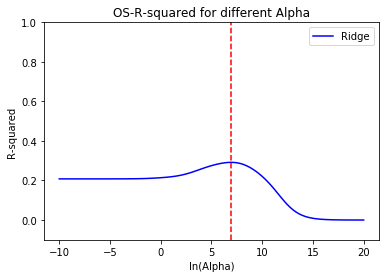

Optimal alpha for Ridge=1063.900307652953, best OS R_2=0.29180436975799295


In [63]:
alphas = np.exp(np.linspace(-10,20,100)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(1,REsample1_31,label1,REsample2_31,label2,alphas,Graph=True,logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565635642910423.5, tolerance: 566321910152.5015
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565635398620433.0, tolerance: 566321910152.5015
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565635067862691.2, tolerance: 566321910152.5015
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1557362146110777.8, tolerance: 566321910152.5015
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1554442120033099.0, tolerance: 566321910152.5015
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1550495642486602.8, tolerance: 566321910152.5015
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

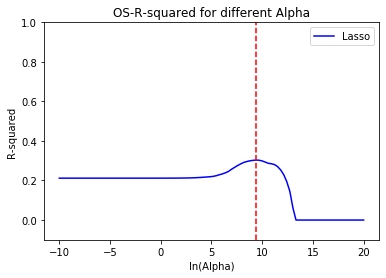

Optimal alpha for Lasso=12015.339377705404, best OS R_2=0.30322440380794224


In [64]:
phas = np.exp(np.linspace(-10,20,100)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(2,REsample1_31,label1,REsample2_31,label2,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

In [65]:
Ridge=linear_model.Ridge(fit_intercept=True, alpha=alpha_optimal)

Ridge.fit(REsample1_31,label1)
# In sample:
YPred_IS=Ridge.predict(REsample1_31)
print("The IS R-squared of Lasso is: {0}".format(r2_score(label1,YPred_IS)))
#Out of sample
YPred_OS=Ridge.predict((REsample3_31))
print("The OS R-squared of Lasso is: {0}".format(r2_score(label3,YPred_OS)))
Ridge.coef_

The IS R-squared of Lasso is: 0.30621049840369374
The OS R-squared of Lasso is: 0.3466219244719273


array([ 1.40067286e+04,  6.46755710e+04, -1.94051270e+03, -3.20155082e+03,
       -1.12144466e+04,  2.51386857e+04, -6.77474665e+03,  2.81889061e+03,
        3.81900807e+03,  7.19659473e+03,  1.09891357e+04, -1.03108774e+04,
        1.51958020e+04,  1.17591338e+04, -1.54303349e+04,  6.13125080e+03,
        1.47496984e+02, -4.84175190e+03,  2.92655795e+04,  3.04973361e+03,
        2.91959069e+04, -4.39362068e+03,  7.78257718e+02, -1.77139725e+03,
       -2.18800909e+03,  2.08450385e+03,  3.53500885e+03, -3.98478773e+03,
       -2.12831681e+03, -5.80064886e+03, -4.94225276e+03,  8.35192707e+04,
        1.41860133e+04, -9.82766534e+01, -4.14313518e+02,  4.52983408e+03,
       -3.15376398e+03, -8.75074929e+03,  1.33025085e+03, -6.17124435e+03,
       -7.41246111e+03,  2.16967607e+03,  3.44116655e+03, -2.42223062e+03,
       -5.89284545e+03, -5.68528807e+03, -2.56392141e+03, -1.41044643e+03,
       -1.22504900e+03,  3.00191125e+03, -9.13320694e+03, -1.57488706e+03,
        3.95487207e+03,  

In [66]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal)

Lasso.fit(REsample1_31,label1)
# In sample:
YPred_IS=Lasso.predict(REsample1_31)
print("The IS R-squared of Lasso is: {0}".format(r2_score(label1,YPred_IS)))
#Out of sample
YPred_OS=Lasso.predict((REsample3_31))
print("The OS R-squared of Lasso is: {0}".format(r2_score(label3,YPred_OS)))
Lasso.coef_

The IS R-squared of Lasso is: 0.3893912522220614
The OS R-squared of Lasso is: 0.3634580826260433


array([  5095.24762542, 164543.35478417,     -0.        ,      0.        ,
           -0.        ,      0.        ,     -0.        ,      0.        ,
       -31541.44846696, -13577.62976853,      0.        ,     -0.        ,
        51250.53567096,     -0.        ,     -0.        ,      0.        ,
         4401.81089429,      0.        ,  66507.90311338,     -0.        ,
        32397.06368206,     -0.        ,      0.        ,  -8479.39357094,
        -4229.03060641,  10367.11739996,  13753.69126774,      0.        ,
           -0.        , -18642.22048171,     -0.        , 396343.47291429,
           -0.        ,      0.        ,     -0.        , -16783.10878049,
           -0.        ,     -0.        ,  14538.49752029,     -0.        ,
           -0.        ,      0.        , -86971.96309697,      0.        ,
        -9075.67874468,      0.        ,     -0.        ,  -4850.48637662,
           -0.        ,     -0.        , -47232.45950797,     -0.        ,
            0.        ,  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565635642910423.5, tolerance: 566321910152.5015
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565635398620433.0, tolerance: 566321910152.5015
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565635067862691.2, tolerance: 566321910152.5015
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1557362146110777.8, tolerance: 566321910152.5015
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1554442120033099.0, tolerance: 566321910152.5015
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1550495642486602.8, tolerance: 566321910152.5015
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

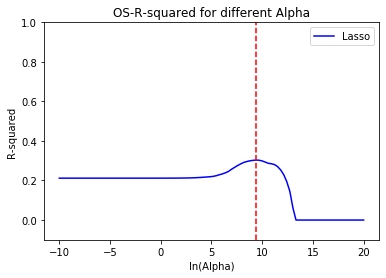

Optimal alpha for Ridge=12015.339377705404, best OS R_2=0.30322440380794224


In [67]:
alphas = np.exp(np.linspace(-10,20,100)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(2,REsample1_31,label1,REsample2_31,label2,alphas,Graph=True,logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

In [68]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal)

Lasso.fit(REsample1_31,label1)
# In sample:
YPred_IS=Lasso.predict(REsample1_31)
print("The IS R-squared of Lasso is: {0}".format(r2_score(label1,YPred_IS)))
#Out of sample
YPred_OS=Lasso.predict((REsample3_31))
print("The OS R-squared of Lasso is: {0}".format(r2_score(label3,YPred_OS)))
Lasso.coef_

The IS R-squared of Lasso is: 0.3893912522220614
The OS R-squared of Lasso is: 0.3634580826260433


array([  5095.24762542, 164543.35478417,     -0.        ,      0.        ,
           -0.        ,      0.        ,     -0.        ,      0.        ,
       -31541.44846696, -13577.62976853,      0.        ,     -0.        ,
        51250.53567096,     -0.        ,     -0.        ,      0.        ,
         4401.81089429,      0.        ,  66507.90311338,     -0.        ,
        32397.06368206,     -0.        ,      0.        ,  -8479.39357094,
        -4229.03060641,  10367.11739996,  13753.69126774,      0.        ,
           -0.        , -18642.22048171,     -0.        , 396343.47291429,
           -0.        ,      0.        ,     -0.        , -16783.10878049,
           -0.        ,     -0.        ,  14538.49752029,     -0.        ,
           -0.        ,      0.        , -86971.96309697,      0.        ,
        -9075.67874468,      0.        ,     -0.        ,  -4850.48637662,
           -0.        ,     -0.        , -47232.45950797,     -0.        ,
            0.        ,  

#### Task 2. Model Mean income of the zip code population using 311 profile of the neighborhood

In [69]:
#load the data
dataIncome=pd.read_csv(folder+"data/MeanZip.csv",index_col=0)
dataIncome=dataIncome.apply(pd.to_numeric, errors='coerce')
dataIncome=dataIncome.loc[dataIncome.Mean>0]
dataIncome.head()

,Median,Mean,Pop
Zip,,,
1001,56662.5735,66687.7509,16445
1002,49853.4177,75062.6343,28069
1003,28462.0000,35121.0000,8491
1005,75423.0000,82442.0000,4798
1007,79076.3540,85801.9750,12962


#### Q1. Perform regularied regression of Mean income of the zip code vs its 311 profile 
Train Ridge and Lasso over dataIncome1 with an arbitrary default parameter $\alpha=100$.
Then evaluate their out-of-sample performance over dataIncome3
Make sure to scale the features in all three samples first, learning the scaler over the training sample

In [70]:
 dataIncome = pd.merge( dataIncome, data311,how='inner',left_on=['Zip'], right_index=True)

In [71]:
 dataIncome.head()

,Median,Mean,Pop,F1,F2,F3,F4,F5,F6,F7,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
Zip,,,,,,,,,,,,,,,,,,,,,
10001,71244.6100,123112.7764,17678,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,...,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002,30843.9574,46258.6118,70878,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003,89998.5339,139330.9968,53609,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,...,0.000621,0.000976,0.000177,0.004792,0.002218,0.001065,0.000444,0.028219,0.0,0.0
10004,110183.6857,156682.7615,1271,0.000000,0.000000,0.009740,0.0,0.000000,0.002597,0.001948,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.0,0.0
10005,115133.2855,163762.6601,1517,0.000000,0.000000,0.008219,0.0,0.000000,0.002192,0.000548,...,0.000000,0.000000,0.000000,0.013699,0.000000,0.000548,0.000000,0.019726,0.0,0.0


In [72]:
#split into training (1), validation (2) and test (3) samples
np.random.seed(2018)
splitind=np.random.uniform(size=len(dataIncome))
dataIncome1=dataIncome.loc[splitind<=0.4]
dataIncome2=dataIncome.loc[(splitind>0.4)&(splitind<0.7)]
dataIncome3=dataIncome.loc[(splitind>=0.7)]

In [73]:
#dataIncome2 = pd.merge( dataIncome2, data311,how='inner',left_on=['Zip'], right_index=True)

In [74]:
 #dataIncome3 = pd.merge( dataIncome3, data311,how='inner',left_on=['Zip'], right_index=True)

In [75]:
 dataIncome1.head()

,Median,Mean,Pop,F1,F2,F3,F4,F5,F6,F7,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
Zip,,,,,,,,,,,,,,,,,,,,,
10002,30843.9574,46258.6118,70878,0.001330,0.000000,0.007095,0.0,0.0,0.001862,0.001596,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10004,110183.6857,156682.7615,1271,0.000000,0.000000,0.009740,0.0,0.0,0.002597,0.001948,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.0,0.0
10011,92359.4888,160936.5432,45899,0.001200,0.000100,0.015000,0.0,0.0,0.001100,0.003300,...,0.000900,0.000800,0.000000,0.005100,0.003200,0.000600,0.001200,0.032800,0.0,0.0
10016,96760.4462,144872.3901,49904,0.001143,0.000104,0.010907,0.0,0.0,0.000208,0.002597,...,0.000312,0.000208,0.000208,0.022021,0.000519,0.000727,0.000831,0.030851,0.0,0.0
10017,102523.5025,149723.7834,16231,0.000227,0.000000,0.010658,0.0,0.0,0.000227,0.003855,...,0.000227,0.000227,0.000000,0.010658,0.000454,0.001814,0.000227,0.050794,0.0,0.0


In [76]:
label11 = dataIncome1['Mean']

In [77]:
 dataIncome1=  dataIncome1.drop(['Mean','Median','Pop','F81','F108','F136' ], axis=1)

In [78]:
label21 = dataIncome2['Mean']

In [79]:
 dataIncome2=  dataIncome2.drop(['Mean','Median','Pop','F81','F108','F136' ], axis=1)

In [80]:
label31 = dataIncome3['Mean']

In [81]:
 dataIncome3=  dataIncome3.drop(['Mean','Median','Pop','F81','F108','F136'], axis=1)

In [82]:
mu= dataIncome1.iloc[:,1:].mean()
sigma= dataIncome1.iloc[:,1:].std() 

In [83]:
sigma.loc[sigma==0]

Series([], dtype: float64)

In [84]:
 dataIncome1.iloc[:,0:].head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
Zip,,,,,,,,,,,,,,,,,,,,,
10002,0.001330,0.000000,0.007095,0.0,0.0,0.001862,0.001596,0.001774,0.000177,0.000532,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10004,0.000000,0.000000,0.009740,0.0,0.0,0.002597,0.001948,0.000649,0.000000,0.000649,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.0,0.0
10011,0.001200,0.000100,0.015000,0.0,0.0,0.001100,0.003300,0.002500,0.000300,0.000600,...,0.000900,0.000800,0.000000,0.005100,0.003200,0.000600,0.001200,0.032800,0.0,0.0
10016,0.001143,0.000104,0.010907,0.0,0.0,0.000208,0.002597,0.002181,0.000000,0.000104,...,0.000312,0.000208,0.000208,0.022021,0.000519,0.000727,0.000831,0.030851,0.0,0.0
10017,0.000227,0.000000,0.010658,0.0,0.0,0.000227,0.003855,0.001361,0.000000,0.000000,...,0.000227,0.000227,0.000000,0.010658,0.000454,0.001814,0.000227,0.050794,0.0,0.0


In [85]:
 dataIncome1.iloc[:,1:]=(dataIncome1.iloc[:,1:]-mu)/sigma
    

In [86]:
 dataIncome2.iloc[:,1:]=(dataIncome2.iloc[:,1:]-mu)/sigma
    

In [87]:
 dataIncome3.iloc[:,1:]=(dataIncome3.iloc[:,1:]-mu)/sigma
    

In [88]:
dataIncome3.head()


,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
Zip,,,,,,,,,,,,,,,,,,,,,
10001,0.000000,2.280012,0.724361,-0.409624,-0.440756,-0.607769,0.993277,2.558298,-0.002119,0.193849,...,-0.034114,-0.713505,-0.485546,0.360265,-0.272955,-0.618187,-0.868537,1.170669,-0.300988,-0.164028
10003,0.001331,1.259061,0.669790,-0.409624,0.884944,1.458376,0.389857,0.019397,0.097181,0.338975,...,0.234072,1.253266,-0.548410,0.087825,0.441133,-0.491386,-0.666805,-0.405130,-0.300988,-0.164028
10007,0.000000,-0.311227,0.944295,-0.409624,-0.440756,-0.463139,-0.290816,2.337806,-0.470522,-0.490719,...,0.525788,-0.713505,-0.645100,1.184114,2.129672,-0.741167,-0.164831,0.487160,-0.300988,-0.164028
10010,0.000207,3.345639,0.406978,-0.409624,-0.440756,-0.461045,0.966445,0.200024,1.512568,0.475372,...,-0.377177,0.119257,-0.645100,-0.000280,-0.426151,-0.345904,0.950961,0.178100,-0.300988,-0.164028
10012,0.000562,14.617546,0.524781,-0.409624,-0.440756,0.007460,0.905260,0.175051,-0.470522,0.823936,...,-0.059891,-0.146894,-0.568497,1.560996,-0.489615,-0.682881,-0.319934,-0.341334,-0.300988,-0.164028


In [89]:
 #dataIncome11=dataIncome1.replace([np.inf,-np.inf,np.nan],0)
#label111=label11.replace([np.inf,-np.inf,np.nan],0)

In [90]:

Ridge=linear_model.Ridge(fit_intercept=True,alpha=100)
Ridge.fit(dataIncome1,label11)
# In sample:
MeanPred_IS=Ridge.predict(dataIncome1)
print("The IS R-squared of Ridge is: {0}".format(r2_score( label11,MeanPred_IS)))
Ridge.coef_




The IS R-squared of Ridge is: 0.9139180116569776


array([-2.86448375e+00, -4.06412517e+02,  1.76680543e+03, -1.44091313e+03,
       -1.99725868e+01,  9.35091403e+02,  2.26034300e+03,  3.05963667e+02,
        1.82521911e+01,  7.51022140e+02, -7.35634175e+02, -1.50464351e+03,
        5.71880153e+02, -5.73888377e+01,  4.10089414e+02,  2.74669332e+03,
       -9.12698311e+02,  6.31201565e+02, -6.26516577e+02, -3.92772198e+02,
        1.07470725e+03,  1.31316766e+03, -6.03088050e+02,  6.34042209e+02,
       -6.95414488e+02, -2.96642758e+02, -9.42594287e+01, -7.10069965e+02,
        2.00847712e+03, -9.02303119e+02,  5.91872738e+02,  6.02274661e+02,
        1.04368429e+03, -2.10493316e+02, -6.21766075e+02,  3.38919631e+02,
       -4.88856987e+02, -2.15050614e+03,  7.57646671e+02,  1.47406931e+02,
       -6.49875466e+02,  1.24691722e+02, -1.55003921e+03, -4.76347933e+01,
        6.59845998e+02,  3.25446712e+02,  5.53863753e+01,  7.19260269e+02,
       -1.31049587e+03,  1.88316534e+02,  1.18473545e+03,  7.68232060e+02,
        1.81806644e+01,  

In [91]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=100)

Lasso.fit(dataIncome1,label11)
# In sample:
MeanPred_IS=Lasso.predict(dataIncome1)
print("The IS R-squared of Lasso is: {0}".format(r2_score(label11,MeanPred_IS)))
#Out of sample
MeanPred_OS=Lasso.predict(dataIncome3)
print("The OS R-squared of Lasso is: {0}".format(r2_score(label31,MeanPred_OS)))
Lasso.coef_

The IS R-squared of Lasso is: 0.998682202095112
The OS R-squared of Lasso is: -0.4911904432220249


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57092508.318116546, tolerance: 12626796.945673358
  positive)


array([-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.40481816e+03,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -1.05928429e+03,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -8.20523844e+02,  0.00000000e+00,  0.00000000e+00,  3.17229443e+01,
       -4.19221511e+03,  3.47304810e+03,  0.00000000e+00,  0.00000000e+00,
        3.79420860e+03,  6.82132813e+02, -8.66610224e+02,  1.24495188e+02,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.29666023e+03,  3.81476501e+02,  0.00000000e+00,
        3.50852491e+03,  0.00000000e+00,  9.35289467e+02,  1.53127389e+02,
       -0.00000000e+00, -0.00000000e+00,  8.88656457e+02, -0.00000000e+00,
       -6.03326951e+03, -0.00000000e+00, -2.02776221e+03,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -1.07548285e+04, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  

#### Q2. Perform parameter selection for Lasso and Ridge over validation sample
try exponential range exp(-10)...exp(20) with 100 values in it

Visualize the validation R2 vs alpha

For the optimal alpha evaluate performance of the models over the test set. 

Why do you think performance does not look that good, especially for one of the models?

In [92]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model,X_train,y_train,X_valid,y_valid,alphas,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso
    #aplhas: a list of aplha values to try
    #Graph: plot the graph of R^2 values for different alpha

    R_2_OS=[] #out of sample R2's
    
    #initialize the model to use for each given alpha
    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    
    best_R2 = -1
    best_alpha = alphas[0]
    best_coefs = []
    
    for a in alphas: #for all alphas to try
        lm = RM(a) #assign the model
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        R_2_OS_=r2_score(y_valid,y_predict)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2: #if current OS R2 is the best - update the best solution
            best_R2 = R_2_OS_
            best_alpha = a
            best_coefs = lm.coef_
    
    if Graph==True: #visualization of the performance depending on alpha
        plt.title('OS-R-squared for different Alpha')
        if logl: #log-scale
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.ylim((-0.1,1))
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return [best_alpha,best_R2,best_coefs]

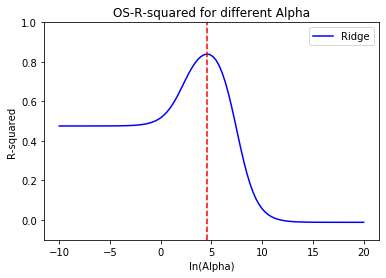

Optimal alpha for Ridge=94.20323713238389, best OS R_2=0.8396090566146639


In [93]:
alphas = np.exp(np.linspace(-10,20,100)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(1,dataIncome1,label11,dataIncome2,label21,alphas,Graph=True,logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16857792.68972491, tolerance: 12626796.945673358
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21283658.650232624, tolerance: 12626796.945673358
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27402604.893945698, tolerance: 12626796.945673358
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

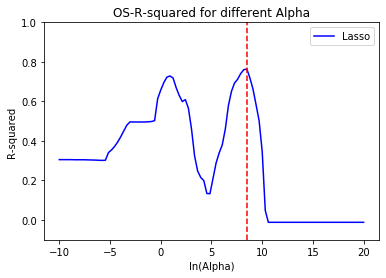

Optimal alpha for Ridge=4840.863945165378, best OS R_2=0.7641167705578529


In [94]:
alphas = np.exp(np.linspace(-10,20,100)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(2,dataIncome1,label11,dataIncome2,label21,alphas,Graph=True,logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

In [95]:
Ridge=linear_model.Ridge(fit_intercept=True, alpha=alpha_optimal)

Ridge.fit(dataIncome1,label11)
# In sample:
YPred_IS=Ridge.predict(dataIncome1)
print("The IS R-squared of Lasso is: {0}".format(r2_score(label11,YPred_IS)))
#Out of sample
YPred_OS=Ridge.predict((dataIncome3))
print("The OS R-squared of Lasso is: {0}".format(r2_score(label31,YPred_OS)))
Ridge.coef_

The IS R-squared of Lasso is: 0.22252994960412298
The OS R-squared of Lasso is: 0.2199887367795158


array([  -0.52103252,  -51.54673104,  251.07090631, -158.15218226,
          2.0438586 ,  116.23751067,  239.69895489,  144.96822779,
         -0.60009046,  152.4639817 ,   99.96223309, -173.32739899,
         23.82919635,    9.62364002,   54.10628462,  296.53828404,
         34.84634157,   88.5857116 , -108.48350758,  -43.92990584,
        -29.22251668,  131.60436557,   53.1004162 ,  149.79331737,
        -65.32359237,  141.59102511,   80.11300478,  -98.35125873,
        265.00850693,   78.26428975,   -8.04327717,    7.12017597,
        151.13675321,  -70.71142066, -139.18599139,  -68.06059964,
         -5.43312382, -186.45399902,   -3.57025977,  171.98386207,
       -201.47780832,  -18.66448377, -121.83395271,  -21.43787372,
        143.20568916,  151.62117058,  138.6087706 ,  169.22075342,
         44.0281338 ,  164.58509863,  244.25743346,  247.21948186,
        114.64001179,  292.77562171, -113.93733972, -218.41909829,
         70.25813658, -204.82101635, -189.08406766,  -92.72439